# Signal Processing Examples

In [1]:
import numpy as np
from stream import StreamArray, run
from example_operators import sliding_window

In [2]:
# GENERATE WAVE FOR TESTING

def generate_trignometric_wave(
        func, frequency, max_amplitude,
        phase_shift, sample_rate, time_duration):
    num_samples = int(time_duration * sample_rate)
    time_sequence = np.linspace(0, time_duration, num_samples, endpoint=False)
    return max_amplitude*func(2*np.pi*(frequency*time_sequence) + phase_shift)

In [3]:
# GENERATE WAVE FOR TESTING

def generate_sine_wave(
        frequency, max_amplitude, phase_shift,
        sample_rate, time_duration):
    return generate_trignometric_wave(
        np.sin, frequency, max_amplitude, phase_shift,
        sample_rate, time_duration)

In [4]:
# GENERATE WAVE FOR TESTING

def generate_cosine_wave(
        frequency, max_amplitude, phase_shift,
        sample_rate, time_duration):
    return generate_trignometric_wave(
        np.cos, frequency, max_amplitude, phase_shift,
        sample_rate, time_duration)

In [5]:
# GENERATE WAVE FOR TESTING

def generate_square_wave(
        frequency, max_amplitude,
        phase_shift, sample_rate, time_duration):
    num_samples = time_duration * sample_rate
    time_sequence = np.linspace(0, time_duration, num_samples, endpoint=False)
    def func(v):
        return - np.sign((v - v.astype(int)) - 0.45)
    return max_amplitude*func(frequency*time_sequence + phase_shift)

In [6]:
class Filter(object):
    """
    The base class of filters that filter input streams to
    produce output streams.
    Uses a, b parameters from scipy.signal or other libraries.

    Parameters
    ----------
    a, b: list of float
      Parameters that define a filter.
      For a Finite Impulse Response filter, a is None.

    Attributes
    ----------
    N: int
      the length of b
    x: array of float
      The N most recent values of the input stream.
      x[0] is the most recent value. For example if
      the current value of in_stream is:
      in_stream[j-N+1, ... j] then
      x[k] = in_stream[j - k]
      x is initialized to 0.
    y: array of float
      The N most recent values of the output stream.
      Initialized to 0.
      y and x have the same structure.

    """
    def __init__(self, b, a=None):
        self.b = np.array(b)
        if a is not None:
            self.a = np.array(a)
        self.N = len(b)
        self.x = np.zeros(self.N)
        self.y = np.zeros(self.N)

    def filter_element(self, element):
        """
        This is the standard filter calculation.
        The formula depends on the type of filter.
        The formula must be entered for the subclass
        derived from the base Filter class.

        Parameters
        ----------
        element: float or int
          The next element of the stream.
          
        Returns
        -------
          The next element of the output stream.
        """
        pass

In [7]:
# BANDPASS FIR (FINITE IMPULSE RESPONSE) FILTER.

class BP_FIR(Filter):
    """
    Bandpass FIR (Finite Impulse Response) Filter.

    Parameters
    ----------
       b: float or int
          Filter parameters obtained from scipy.signal.butter
          or other sources.
          Filter parameters are a, b. For this filter a is None.

    """
    def __init__(self, b):
        Filter.__init__(self, b)

    def filter_element(self, element):
        """
        Parameter
        ---------
        element: an element of the input stream
        
        Returns
        -------
            float: the next element of the output stream.
        
        Uses a standard formula for FIR filters.
        x is an array of the most recent values of the input stream.
        x is specified in the parent class: Filter

        """
        # Shift x to the right by 1 to make x[0] empty
        self.x[1:] = self.x[:- 1]
        self.x[0] = element
        return np.sum(self.b * self.x)

In [8]:
class BP_IIR(Filter):
    """
    Bandpass IIR (Infinite Impulse Response) Filter.

    Parameters
    ----------
       b, a: float or int
          Filter parameters obtained from scipy.signal.butter
          or other sources.

    """
    def __init__(self, b, a):
        Filter.__init__(self, b, a)

    def filter_element(self, element, **kwargs):
        """
        Parameter
        ---------
        element: element of the input stream
        
        Returns
        -------
            float: the output sequence is the dsp filter of
                   the input stream.
        
        Uses a standard formula for IIR filters.
        Shifts x, y to the right by 1 to accomodate
        new entry for input x, and then updates y[0].

        """
        # Insert a new value -- element --- into x[0].
        # First shift x to the right by 1 to make x[0] empty.
        self.x[1:] = self.x[:- 1]
        self.x[0] = element
        
        # Insert a new value into y[0].
        # First shift y to the right by 1 to make y[0] empty.
        self.y[1:] = self.y[:-1]
        # Compute new value for y[0]
        self.y[0] = self.b[0] * self.x[0]
        self.y[0] += sum(self.b[1:]*self.x[1:] -
                         self.a[1:]*self.y[1:])
        return self.y[0]

In [9]:
# See scipy.signal for a library of filters.
from scipy.signal import butter, firwin
def butter_bandpass(lowcut, highcut, fs, order=2):
    """
    Returns filter parameters b, a given input parameters.
    Butterworth IIR filter.
    butter() is from scipy.signal

    """
    lowcut, highcut = lowcut*2.0/fs, highcut*2.0/fs
    b, a = butter(order, [lowcut, highcut], btype='band')
    return b, a

In [10]:
def fir_bandpass(lowcut, highcut, fs):
    """
    Returns filter parameters b given input parameters.
    FIR filter.
    firwin() is from scipy.signal

    """
    lowcut, highcut =lowcut*2.0/fs, highcut*2.0/fs
    b =  firwin(
        numtaps=201, cutoff = [lowcut, highcut],
        window='blackmanharris', pass_zero=False)
    return b 

In [11]:
# SET PARAMETERS OF FILTER
# fs: sample rate
# order: order of the filter
# lowcut, highcut: lower and upper thresholds of a bandpass
# filter.
fs, order, lowcut, highcut = 50.0, 4, 1.0, 4.0

In [12]:
# SPECIFY WAVEFORM PARAMETERS
low_frequency=0.1,
medium_frequency = 2.0
high_frequency = 10.0
max_amplitude=1.0, 
phase_shift=0.0, 
sample_rate=fs,
time_duration=10.0

# GENERATE WAVEFORMS LOW, MEDIUM, HIGH FREQUENCY AND
# SUM OF WAVEFORMS.
wave_data_low_frequency = generate_sine_wave(
    low_frequency, max_amplitude, phase_shift,
    fs, time_duration)
wave_data_medium_frequency = generate_sine_wave(
    medium_frequency, max_amplitude, phase_shift,
    fs, time_duration)
wave_data_high_frequency = generate_sine_wave(
    high_frequency, max_amplitude, phase_shift,
    fs, time_duration)
wave_data_total = (wave_data_low_frequency +
                   wave_data_medium_frequency +
                   wave_data_high_frequency)

In [13]:
# TEST BANDPASS IIR FILTER

from example_operators import single_item

import matplotlib.pyplot as plt
%matplotlib inline

x = StreamArray('x')
y = StreamArray('y')

# Create bandpass filter 
b, a = butter_bandpass(lowcut, highcut, fs, order)
filter_object = BP_IIR(b, a)

def func(element, out_stream):
    v = filter_object.filter_element(element)
    out_stream.append(v)
    
# Create agent
single_item(in_stream=x, func=func, out_stream=y)
#BP_IIR(b, a).filter_stream(in_stream=x, out_stream=y)
x.extend(wave_data_total)
run()

500


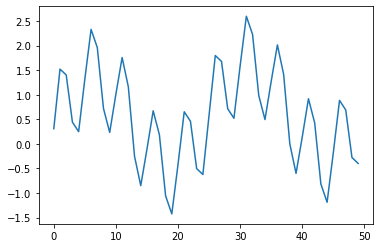

In [14]:
# LOOK AT INPUT WAVEFORM
print(len(x.recent_values()))
plt.plot(x.recent_values()[25:75])
plt.show()

500


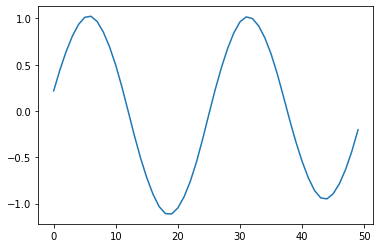

In [15]:
# LOOK AT FILTERED WAVEFORM

print (len(y.recent_values()))
plt.plot(y.recent_values()[25:75])
plt.show()

In [16]:
# WINDOW_DOT_PRODUCT

# Create agent with input stream, output stream, and 
# keyword argument, multiplicand_vector.
# Elements of the output stream are dot products of window and multiplicand_vector.
# window is from a sliding window that slides forward with a step_size of 1.
# The length of window is set to that of multiplicand_vector.

class WindowDotProduct(object):
    def __init__(self, in_stream, out_stream, multiplicand_vector):
        self.in_stream = in_stream
        self.out_stream = out_stream
        self.multiplicand_vector = multiplicand_vector
        # Create the agent
        sliding_window(in_stream=self.in_stream,
                       window_size=len(self.multiplicand_vector), step_size=1,
                       func=self.func)
                       
    # The callback function
    def func(self, window):
        self.out_stream.append(np.dot(window, self.multiplicand_vector))

In [17]:
# TEST BANDPASS FIR FILTER

def bandpass_FIR(in_stream, out_stream, b):
    """
    Creates an agent that executes a
    FIR (Finite Impulse Response) filter of
    in_stream to produce out_stream using
    filter parameter b.
    Parameters
    ----------
       in_stream: Stream
       out_stream: Stream
       b: array
    Note
    ----
    out_stream[n] = sum over k in [0, M] of b[k]*in_stream[n-k]
    Therefore, setting k to M-k:
    out_stream[n] = sum over k in [0, M] of b[M-k]*in_stream[n-M+k]
    So, out_stream[n] is the dot product of the reverse of b and
    the in_stream window consisting of: in_stream[n-M]... in_stream[M].

    """
    # Instantiate an instantiate of the WindowDotProduct class.
    WindowDotProduct(in_stream, out_stream, multiplicand_vector=np.flip(b))

In [18]:
x = StreamArray('x')
y = StreamArray('y')

b = fir_bandpass(lowcut, highcut, fs)
bandpass_FIR(in_stream=x, out_stream=y, b=b)

x.extend(wave_data_total)
run()

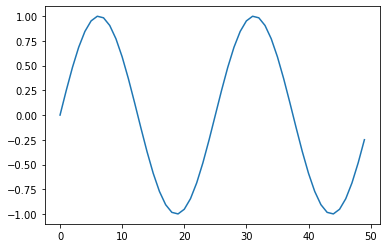

In [19]:
# LOOK AT FILTERED WAVEFORM
plt.plot(y.recent_values()[25:75])
plt.show()